# Machine learning models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
relation = pd.read_csv('relation.csv', index_col=0)

In [3]:
relation = relation.apply(lambda x: x.astype('category'))
relation['mh_leave_request'] = relation['mh_leave_request'].cat.as_ordered()

In [4]:
col_names = ['company_size', 'tech_company', 'enterprise_mh_benefit',
       'enterprise_mh_options', 'enterprise_mh_emphasis',
       'enterprise_offer_resources', 'anonymity_protection',
       'mh_leave_request', 'family_history',
       'gender', 'remote', 'age_class']
X = relation[col_names]
y = relation['diagnosed']


In [5]:
# to fit the model which cannot recognize string.
y = y.replace('Yes', 1)
y = y.replace('No', 0)

In [6]:
X = pd.get_dummies(X, drop_first=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [8]:
# checking target label distribution in test part.
y_test.value_counts()

0    175
1    169
Name: diagnosed, dtype: int64

In [9]:
names = ['SVC', 'Logistic Regression', 'RandomForestClassifier', 'Decision Tree', 'GradientBoostingClassifier', 'XG Boost']
models = [SVC(), LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier(), \
         GradientBoostingClassifier(), XGBClassifier()]
model_dict = dict(zip(models, names))


In [10]:
def model_fit(model, X_train, y_train):
    model.fit(X_train, y_train)
    train_score = roc_auc_score(y_train, model.predict(X_train))
    test_score = roc_auc_score(y_test, model.predict(X_test))
    return (train_score, test_score)

In [11]:
def model_search_report(X_train, y_train):
    
    # prepare scores
    train_scores = {}
    test_scores = {}
    for model, name in model_dict.items():
        train_score, test_score = model_fit(model, X_train, y_train)
        train_scores[name] = train_score
        test_scores[name] = test_score
        
    # prepare reports
    report = pd.DataFrame()
    report['model'] = names
    report['train_score'] = train_scores.values()
    report['test_score'] = test_scores.values()
    
    print(report.sort_values(by='test_score'))
    

In [12]:
model_search_report(X_train, y_train)

                        model  train_score  test_score
3               Decision Tree     0.998744    0.570448
2      RandomForestClassifier     0.976243    0.627895
5                    XG Boost     0.785748    0.667067
4  GradientBoostingClassifier     0.791973    0.669620
0                         SVC     0.695669    0.706661
1         Logistic Regression     0.724414    0.721860


** Logistic Regression gives the best prediction model. XG Boost need some numerical value for classification prediction. So it doesn't show a good result.

### RandomForest for feature importance using default parameters.

In [13]:
features = X.columns

In [14]:
rf = RandomForestClassifier()

In [15]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
importances = rf.feature_importances_

In [17]:
indices = np.argsort(importances)

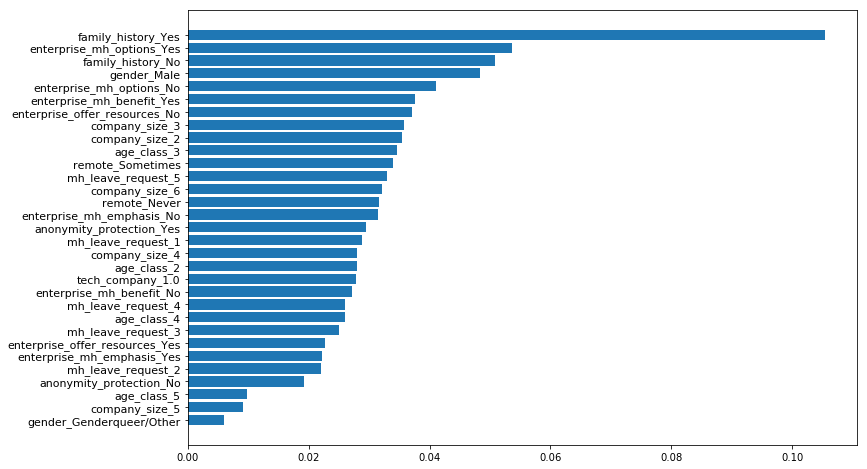

In [18]:
plt.clf()
plt.subplots(figsize=(12, 8))
plt.barh(range(len(rf.feature_importances_)), importances[indices])
plt.yticks(np.arange(len(features)), features[indices], fontsize=11)
plt.show()

### XG boost for feature importances

In [19]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [20]:
importances = xgb.feature_importances_
indices = np.argsort(importances)

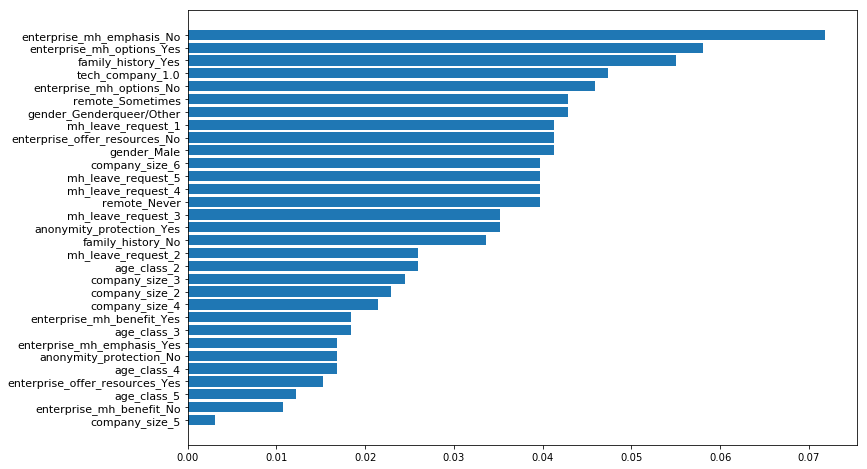

In [21]:
plt.clf()
plt.subplots(figsize=(12, 8))
plt.barh(range(len(features)), importances[indices])
plt.yticks(np.arange(len(features)), features[indices], fontsize=11)
plt.show()

** Also XGBoost doesn't show the meaningful feature importances.

### LogisticRegression brute-force feature search

In [22]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print(logreg.coef_)

[[ 0.04191744  0.42110412  0.33012099  0.11597203  0.34292759  0.06838387
   0.14249913  0.25349752 -0.52709156  0.87211907  0.30695257  0.10320851
  -0.01168611  0.0037555  -0.31511343 -0.16491673 -0.34739122 -0.02581699
   0.06693441  0.07456306  0.25986664 -0.69629289  1.02578569  0.79231512
  -0.45345661  0.03559118  0.37531696 -0.1001807  -0.10420026 -0.07107747
  -0.21289858]]


In [23]:
score = logreg.coef_[0].tolist()
coef = pd.DataFrame()
coef['col_name'] = X.columns
coef['score'] = score
print(coef.sort_values(by='score', ascending=False))

                          col_name     score
22              family_history_Yes  1.025786
9        enterprise_mh_options_Yes  0.872119
23        gender_Genderqueer/Other  0.792315
1                   company_size_3  0.421104
26                remote_Sometimes  0.375317
4                   company_size_6  0.342928
2                   company_size_4  0.330121
10       enterprise_mh_emphasis_No  0.306953
20              mh_leave_request_5  0.259867
7        enterprise_mh_benefit_Yes  0.253498
6         enterprise_mh_benefit_No  0.142499
3                   company_size_5  0.115972
11      enterprise_mh_emphasis_Yes  0.103209
19              mh_leave_request_4  0.074563
5                 tech_company_1.0  0.068384
18              mh_leave_request_3  0.066934
0                   company_size_2  0.041917
25                    remote_Never  0.035591
13  enterprise_offer_resources_Yes  0.003756
12   enterprise_offer_resources_No -0.011686
17              mh_leave_request_2 -0.025817
29        

In [24]:
# extract all random feature combination groups
feature_bag = {}
index = 1
n = len(col_names)
for i in range(n):
    n_features = i + 1   
    if (n_features <= n):       
        
        for j in range(n - i):
            features = []
            for m in range(n_features):
                features.append(col_names[j + m])
            feature_bag[index] = features
            index += 1   


In [25]:
# collect different feature group roc_auc score
train_scores = {}
test_scores = {}
for key, val in feature_bag.items():
    data = relation[val]
    data = pd.get_dummies(data, drop_first=True)
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=123)
    logreg.fit(X_train, y_train)
    train_scores[key] = roc_auc_score(y_train, logreg.predict(X_train))
    test_scores[key] = roc_auc_score(y_test, logreg.predict(X_test))


In [26]:
# find the top 2 scores
df_scores = pd.DataFrame()
df_scores['train_scores'] = train_scores.values()
df_scores['test_scores'] = test_scores.values()
df_scores.index = feature_bag.keys()
df_scores.sort_values(by='test_scores', ascending=False)

,train_scores,test_scores
39,0.689537,0.741961
47,0.694543,0.733390
65,0.713276,0.724818
78,0.724414,0.721860
76,0.723177,0.721860
68,0.700862,0.721758
62,0.703375,0.721758
56,0.699606,0.721555
69,0.719501,0.718800
63,0.700862,0.718698


In [27]:
feature_bag[78]

['company_size',
 'tech_company',
 'enterprise_mh_benefit',
 'enterprise_mh_options',
 'enterprise_mh_emphasis',
 'enterprise_offer_resources',
 'anonymity_protection',
 'mh_leave_request',
 'family_history',
 'gender',
 'remote',
 'age_class']

### ** feature group 78 was selected for both train_scores and test_scores have relative high values.

In [28]:
cols = feature_bag[78]

In [29]:
data = relation[cols]
data = pd.get_dummies(data, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=123)

In [30]:
y_test.value_counts()

0    175
1    169
Name: diagnosed, dtype: int64

## Using GridSearchCV for parameter searching

### 1. LogisticRegression with GridSearchCV

In [31]:

param_grid = {'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
logreg = LogisticRegression()
cv = GridSearchCV(logreg, param_grid=param_grid, cv=4, scoring='roc_auc')
cv.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [32]:
print('train accuracy score: %f | test accuracy score: %f' % (accuracy_score(y_train, cv.predict(X_train)), accuracy_score(y_test, cv.predict(X_test))))

train accuracy score: 0.719451 | test accuracy score: 0.718023


In [33]:
print('train score: %f | test score: %f' % (cv.score(X_train, y_train), cv.score(X_test, y_test)))

train score: 0.779830 | test score: 0.778698


In [34]:
print('best score: %f | best parameter: %s' % (cv.best_score_, str(cv.best_params_)))

best score: 0.765574 | best parameter: {'C': 0.01}


In [35]:
print(cv.cv_results_)

{'mean_fit_time': array([ 0.00334918,  0.00353062,  0.003815  ,  0.00411701,  0.00353497,
        0.00495005,  0.00493443]), 'std_fit_time': array([ 0.00028092,  0.0005466 ,  0.00106799,  0.00132964,  0.00022382,
        0.00091244,  0.00070872]), 'mean_score_time': array([ 0.00142425,  0.00104088,  0.00110763,  0.0012337 ,  0.00106359,
        0.00105786,  0.00093836]), 'std_score_time': array([ 0.00036502,  0.00020458,  0.00019605,  0.00075221,  0.00024987,
        0.00019361,  0.00029214]), 'param_C': masked_array(data = [1e-05 0.0001 0.001 0.01 0.1 1 10],
             mask = [False False False False False False False],
       fill_value = ?)
, 'params': [{'C': 1e-05}, {'C': 0.0001}, {'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}], 'split0_test_score': array([ 0.78643564,  0.78643564,  0.78584158,  0.78346535,  0.77851485,
        0.77366337,  0.77485149]), 'split1_test_score': array([ 0.71831683,  0.71831683,  0.71742574,  0.71742574,  0.7060396 ,
        0.69217822,  0

In [36]:
logreg1 = LogisticRegression(C=0.01)
logreg1.fit(X_train, y_train)
print('train score: %f | test score: %f' % (roc_auc_score(y_train, logreg1.predict(X_train)), roc_auc_score(y_test, logreg1.predict(X_test))))

train score: 0.719501 | test score: 0.719104


In [37]:
print('train accuracy score: %f | test accuracy score: %f' % (accuracy_score(y_train, logreg1.predict(X_train)), accuracy_score(y_test, logreg1.predict(X_test))))

train accuracy score: 0.719451 | test accuracy score: 0.718023


### 2. SVC with GridSearchCV

In [38]:
params = {'C': np.logspace(-4, 3, 8)}
svc = SVC()
cv = GridSearchCV(svc, param_grid=params, cv=4, scoring='roc_auc')

In [39]:
cv.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [40]:
print('train score: %f | test score: %f' % (cv.score(X_train, y_train), cv.score(X_test, y_test)))

train score: 0.780303 | test score: 0.776061


In [41]:
print('best score: %f | best parameter: %s' % (cv.best_score_, str(cv.best_params_)))

best score: 0.768706 | best parameter: {'C': 0.10000000000000001}


In [42]:
print(confusion_matrix(y_test, cv.predict(X_test)))

[[116  59]
 [ 40 129]]


In [43]:
svc = SVC(C=0.1)
svc.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [44]:
print('train score: %f | test score: %f' % (roc_auc_score(y_train, svc.predict(X_train)), roc_auc_score(y_test, svc.predict(X_test))))

train score: 0.712075 | test score: 0.713085


In [45]:
print(classification_report(y_test, svc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.74      0.66      0.70       175
          1       0.69      0.76      0.72       169

avg / total       0.72      0.71      0.71       344



In [46]:
print(confusion_matrix(y_test, svc.predict(X_test)))

[[116  59]
 [ 40 129]]


### 3. GradientBoostingClassifier with GridSearchCV

In [47]:
params = {'n_estimators': range(10,300,10), 'learning_rate': (0.0001, 0.001, 0.01, 0.1, 0.15, 0.2)}
gbc = GradientBoostingClassifier()
cv = GridSearchCV(gbc, param_grid=params, cv=5, scoring='roc_auc')
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(10, 300, 10), 'learning_rate': (0.0001, 0.001, 0.01, 0.1, 0.15, 0.2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [48]:
print('train score: %f | test score: %f' % (cv.score(X_train, y_train), cv.score(X_test, y_test)))

train score: 0.838279 | test score: 0.745309


In [49]:
print('best score: %f | best parameter: %s' % (cv.best_score_, str(cv.best_params_)))

best score: 0.757834 | best parameter: {'learning_rate': 0.1, 'n_estimators': 40}


In [50]:
gbc1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40)
gbc1.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=40,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [51]:
print('train score: %f | test score: %f' % (roc_auc_score(y_train, gbc1.predict(X_train)), roc_auc_score(y_test, gbc1.predict(X_test))))

train score: 0.757096 | test score: 0.681961


### 4. Simple Neural Network Classification

In [52]:
alphas = np.logspace(-8, 0, 9)
hidden_layer_sizes = [(10, 2), (9, 2), (8, 2), (7, 2), (6, 2), (5, 2)]
best_score = 0
best_alpha = 0
best_hidden_layer_size = (0, 0)
for hidden_layer in hidden_layer_sizes:
    for alpha in alphas:
        clf = MLPClassifier(solver='lbfgs', activation='logistic', alpha=alpha, hidden_layer_sizes=hidden_layer, random_state=1)
        clf.fit(X_train, y_train)
        score = roc_auc_score(y_test, clf.predict(X_test))
        if best_score < score:
            best_score = score
            best_alpha = alpha
            best_hidden_layer_size = hidden_layer
print('best alpha is %f |hidden_layer_size %s ' % (best_alpha, best_hidden_layer_size))
print('best test score: %f\n' % (best_score))
# param_grid = {'alpha': np.logspace(-5, 3, 9)}
# cv = GridSearchCV(clf, param_grid=param_grid, cv=4, scoring='roc_auc')

best alpha is 0.000010 |hidden_layer_size (8, 2) 
best test score: 0.716855



### ** the best test score is 0.716855, the parameters is alpha e1-05, hidden_layer_sizes (8, 2)

## Ensemble model

In [53]:

def model_fit_prediction(X_train, y_train, X_test):
    logreg = LogisticRegression(C=0.01)
    svc = SVC(C=0.1, probability=True)
    gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40)
    mlp = MLPClassifier(solver='lbfgs', activation='logistic', alpha=0.00001, hidden_layer_sizes=(8, 2), random_state=1)
    # fit models
    logreg.fit(X_train, y_train)
    svc.fit(X_train, y_train)
    gbc.fit(X_train, y_train)
    mlp.fit(X_train, y_train)
    # prediction
    prediction = pd.DataFrame()
    prediction['logreg'] = pd.Series(logreg.predict_proba(X_test)[:, 1])
    prediction['svc'] = pd.Series(svc.predict_proba(X_test)[:, 1])
    prediction['gbc'] = pd.Series(gbc.predict_proba(X_test)[:, 1])
    prediction['mlp'] = pd.Series(mlp.predict_proba(X_test)[:, 1])

    predict = []
    for key, row in prediction.iterrows():
        l = row['logreg']
        s = row['svc']
        g = row['gbc']
        m = row['mlp']
        count = 0
        if l >=0.5: count += 1
        if s >= 0.5: count += 1
        if g >= 0.5: count += 1
        if m >= 0.5: count += 1
        if count >= 3: predict.append(1)
        else: predict.append(0)
    prediction['pred'] = predict       
    return prediction['pred']
    

In [54]:
y_pred = model_fit_prediction(X_train, y_train, X_test)

In [55]:
print('train score: %f | test score: %f' % (roc_auc_score(y_train, model_fit_prediction(X_train, y_train, X_train)), roc_auc_score(y_test, y_pred)))

train score: 0.741909 | test score: 0.715943


** from above, single model train score(roc_auc_score): logreg: 0.719501; svc: 0.712075; gbc: 0.757096;

** from above, single model test score(roc_auc_score): logreg: 0.719104; svc: 0.713085; gbc: 0.681961  mlp: 0.716855

In [56]:
print('Accuracy score: train %f | test %f' % (accuracy_score(y_train, model_fit_prediction(X_train, y_train, X_train)), accuracy_score(y_test, y_pred)))

Accuracy score: train 0.741895 | test 0.715116


In [57]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.75      0.67      0.70       175
          1       0.69      0.76      0.72       169

avg / total       0.72      0.72      0.71       344



In [58]:
print(confusion_matrix(y_test, y_pred))

[[117  58]
 [ 40 129]]


## Using Auto-Sklearn Classifier

In [59]:
import autosklearn.classification

In [60]:
clf = autosklearn.classification.AutoSklearnClassifier()
clf.fit(X_train, y_train)

[WARNING] [2018-03-21 10:50:53,557:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2018-03-21 10:50:53,557:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


In [61]:
y_pred = clf.predict(X_test)

In [62]:
print(confusion_matrix(y_test, y_pred))


[[111  64]
 [ 33 136]]


In [63]:
print('train score: {}'.format(roc_auc_score(y_train, clf.predict(X_train))))
print('test score: {}'.format(roc_auc_score(y_test, y_pred)))

train score: 0.7670904025075874
test score: 0.7195097210481827


In [64]:
clf

AutoSklearnClassifier(delete_output_folder_after_terminate=True,
           delete_tmp_folder_after_terminate=True,
           disable_evaluator_output=False, ensemble_nbest=50,
           ensemble_size=50, exclude_estimators=None,
           exclude_preprocessors=None, get_smac_object_callback=None,
           include_estimators=None, include_preprocessors=None,
           initial_configurations_via_metalearning=25,
           ml_memory_limit=3072, output_folder=None,
           per_run_time_limit=360, resampling_strategy='holdout',
           resampling_strategy_arguments=None, seed=1, shared_mode=False,
           smac_scenario_args=None, time_left_for_this_task=3600,
           tmp_folder=None)

In [65]:
print('accuracy score: train %f | test %f' % (accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, y_pred)))

accuracy score: train 0.766833 | test 0.718023


In [66]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.77      0.63      0.70       175
          1       0.68      0.80      0.74       169

avg / total       0.73      0.72      0.72       344



## Conclusion:
    By using answers of 12 questions, we can predict the person's mental health. I tried six classification algorithms, and tuned four methods with best parameters. Finally, I used an ensemble of these four models to do my prediction, and the average precision is 0.72. I also tried the auto-sklearn classifier to do a better ensemble classification models search, which has a little bit better roc-auc socre.